In [1]:
# Import Numpy & PyTorch
import numpy as np
import torch
from sklearn.linear_model import LinearRegression

A tensor is a number, vector, matrix or any n-dimensional array.

## Problem Statement

We'll create a model that predicts crop yeilds for apples (*target variable*) by looking at the average temperature, rainfall and humidity (*input variables or features*) in different regions. 

Here's the training data:

>Temp | Rain | Humidity | Prediction
>--- | --- | --- | ---
> 73 | 67 | 43 | 56
> 91 | 88 | 64 | 81
> 87 | 134 | 58 | 119
> 102 | 43 | 37 | 22
> 69 | 96 | 70 | 103

In a **linear regression** model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

```
yeild_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
```

It means that the yield of apples is a linear or planar function of the temperature, rainfall & humidity.



**Our objective**: Find a suitable set of *weights* and *biases* using the training data, to make accurate predictions.

## Training Data
The training data can be represented using 2 matrices (inputs and targets), each with one row per observation and one column for variable.

In [2]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')

In [3]:
# Target (apples)
targets = np.array([[56], 
                    [81], 
                    [119], 
                    [22], 
                    [103]], dtype='float32')

Before we build a model, we need to convert inputs and targets to PyTorch tensors.

In [4]:
# Convert inputs and targets to tensors
input_tensor = torch.tensor(inputs,requires_grad=True)
print(input_tensor)
target_tensor= torch.tensor(targets,requires_grad=True)
print(target_tensor)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]], requires_grad=True)
tensor([[ 56.],
        [ 81.],
        [119.],
        [ 22.],
        [103.]], requires_grad=True)


## Linear Regression Model (from scratch)

The *weights* and *biases* can also be represented as matrices, initialized with random values. The first row of `w` and the first element of `b` are use to predict the first target variable i.e. yield for apples, and similarly the second for oranges.

In [5]:
# Weights and biases
w = np.array([0.2, 0.5,0.3])
b = 0.1

y = np.matmul(w, input_tensor.detach().numpy().T) + b

The *model* is simply a function that performs a matrix multiplication of the input `x` and the weights `w` (transposed) and adds the bias `b` (replicated for each observation).

$$
\hspace{2.5cm} X \hspace{1.1cm} \times \hspace{1.2cm} W^T \hspace{1.2cm}  + \hspace{1cm} b \hspace{2cm}
$$

$$
\left[ \begin{array}{cc}
73 & 67 & 43 \\
91 & 88 & 64 \\
\vdots & \vdots & \vdots \\
69 & 96 & 70
\end{array} \right]
%
\times
%
\left[ \begin{array}{cc}
w_{11} & w_{21} \\
w_{12} & w_{22} \\
w_{13} & w_{23}
\end{array} \right]
%
+
%
\left[ \begin{array}{cc}
b_{1} & b_{2} \\
b_{1} & b_{2} \\
\vdots & \vdots \\
b_{1} & b_{2} \\
\end{array} \right]
$$

In [6]:
# Define the model

lr = LinearRegression()
lr.fit(input_tensor.detach().numpy(), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The matrix obtained by passing the input data to the model is a set of predictions for the target variables.

In [7]:
# Generate predictions
y_pred=lr.predict(input_tensor.detach().numpy())
print(y_pred)

[ 61.100006  81.5      101.899994  53.100002  82.9     ]


In [8]:
# Compare with targets
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(target_tensor.detach().numpy(), y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(target_tensor.detach().numpy(), y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_tensor.detach().numpy(), y_pred)))


Mean Absolute Error: 14.780002
Mean Squared Error: 337.9781
Root Mean Squared Error: 18.38418


Because we've started with random weights and biases, the model does not perform a good job of predicting the target varaibles.

## Loss Function

We can compare the predictions with the actual targets, using the following method: 
* Calculate the difference between the two matrices (`preds` and `targets`).
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the **mean squared error** (MSE).

In [9]:

def mse(t1, t2):
    diff = t1 - t2
    return np.sum(diff * diff) / diff.size

In [13]:
# Compute loss
preds = model(input_tensor.detach().numpy(),w)
cost_initial = mse(preds, target_tensor.detach().numpy())
print("Cost before regression: ",cost_initial)

Cost before regression:  1482.8080000000002


The resulting number is called the **loss**, because it indicates how bad the model is at predicting the target variables. Lower the loss, better the model. 

## Compute Gradients

With PyTorch, we can automatically compute the gradient or derivative of the `loss` w.r.t. to the weights and biases, because they have `requires_grad` set to `True`.

More on autograd:  https://pytorch.org/docs/stable/autograd.html#module-torch.autograd

In [11]:
# Compute gradients
def model(x,w):
    return x @ w.T

In [12]:
def gradient_descent(X, y, w, learning_rate, n_iters):
    J_history = np.zeros((n_iters,1))
    for i in range(n_iters):
        h = model(X,w)
        diff = h - y
        delta = (learning_rate/y.size)*(X.T@diff)
        new_w = w - delta.T
        w=new_w
        J_history[i] = mse(h, y)
    return (J_history, w)

## Train for multiple epochs

To reduce the loss further, we repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an epoch.

In [14]:
# Train for 100 epochs
import matplotlib.pyplot as plt
n_iters = 500
learning_rate = 0.01

initial_cost = mse(model(input_tensor.detach().numpy(),w),target_tensor.detach().numpy())

print("Initial cost is: ", initial_cost, "\n")

(J_history, optimal_params) = gradient_descent(input_tensor.detach().numpy(), target_tensor.detach().numpy(), w, learning_rate, n_iters)

print("Optimal parameters are: \n", optimal_params, "\n")

print("Final cost is: ", J_history[-1])

Initial cost is:  1482.8080000000002 

Optimal parameters are: 
 [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]] 

Final cost is:  [nan]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in matmul
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


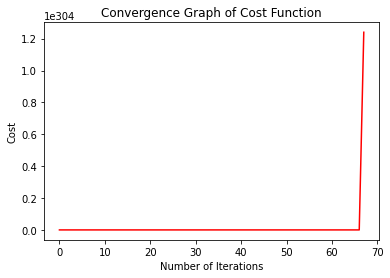

In [15]:
plt.plot(range(len(J_history)), J_history, 'r')

plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()

In [ ]:
# Calculate error
preds = model(X,optimal_params)
cost_final = mse(preds, Y)
# Print predictions
print("Prediction:\n",preds)
# Comparing predicted with targets
print("Targets:\n",Y)

In [ ]:
print("Cost after linear regression: ",cost_final)
print("Cost reduction percentage : {} %".format(((cost_initial- cost_final)/cost_initial)*100))